# Project 1: Binary-Coded GA for Single Objective Optimization

**Deadline**: March 1, 2023 at 10 p.m. Late submissions will result in a 10-point deduction for each hour they are delayed.

**Acceptable Submission formats**: You need to submit this Jupyter Notebook file that clearly displays both the code (in Python 3) and its corresponding results. You need to rename the file to `StudentName_StudentID.ipynb`.

**Please take note that Part 0 is meant to be a comprehensive guide to genetic algorithms and will not be evaluated.**



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

## Part 0: Example of a Simple Binary-Coded GA
In this part, we provide a sample implementation of a binary-coded genetic algorithm for your project, which aims to minimize a single-objective function with one decision variable.
### Objective Function
The objective function we want to minimize is the following function with one decision variable $x$ : $$\mathrm{minimize}~f(x)  = \frac{x^2}{4000}-\cos(x) + 1, -215 \leq x \leq 296.$$

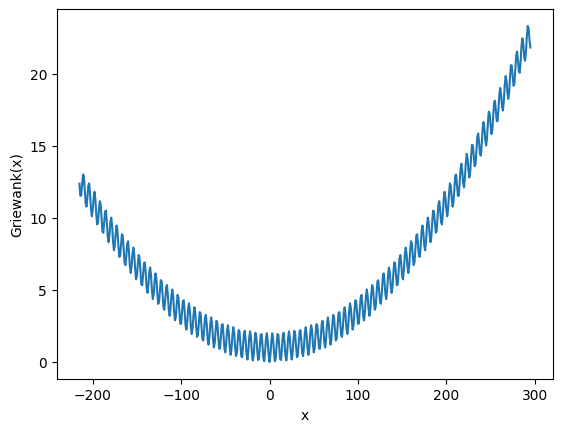

In [2]:
def Griewank(x):
    """
    Calculates the Griewank function value for a given solution point x.

    Parameters:
    x (numpy array): The solution point to be evaluated.

    Returns:
    numpy array: The Griewank function value for each value of x.

    """
    y = x**2 / 4000 - np.cos(x) + 1
    return y

lower_Griewank = -215
upper_Griewank = 296
x = np.arange(lower_Griewank, upper_Griewank)
y = Griewank(x)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("Griewank(x)")
plt.show()

### Binary-Coded GA
We implement a binary-coded GA (using binary representation of individuals) with tournament selection, single point crossover, and bit-flipping mutation to minimize the simplified Griewank function.

In [3]:
def binary_encode(x, lower, upper, code_len):
    """
    Convert a decimal number to a binary coded string.

    Parameters:
    x (int): decimal number
    lower (int): lower bound of the search space
    upper (int): upper bound of the search space
    code_len (int): number of bits in binary string

    Returns:
    str: binary coded string
    """
    x = (x - lower) / (upper - lower) * (2**code_len - 1)
    return format(int(x), f'0{code_len}b')

def binary_decode(binary, lower, upper, code_len):
    """
    Convert a binary coded string to a decimal number.

    Parameters:
    binary (str): binary coded string
    lower (int): lower bound of the search space
    upper (int): upper bound of the search space
    code_len (int): number of bits in binary string

    Returns:
    float: decimal number
    """
    decimal = int(binary, 2)
    return lower + decimal * (upper - lower) / (2**code_len - 1)

In [4]:
encoded = binary_encode(296, -215, 296, 5)
binary_decode(encoded, -215, 296, 5)

296.0

In [5]:
encoded = binary_encode(-215, -215, 296, 5)
binary_decode(encoded, -215, 296, 5)

-215.0

In [6]:
def tournament_selection(pop, fitness, t_size):
    """
    Select a parent from the population using tournament selection.

    Parameters:
    pop (list): population of binary coded strings
    fitness (list): fitness values of the population
    t_size (int): tournament size

    Returns:
    str: binary coded string of selected parent
    """
    tournament = [random.choice(pop) for _ in range(t_size)]
    tournament_fitness = [fitness[pop.index(i)] for i in tournament]
    return tournament[tournament_fitness.index(min(tournament_fitness))]

In [7]:
def single_point_crossover(p1, p2):
    """
    Perform single point crossover to generate two offspring.

    Parameters:
    p1 (str): binary coded string of parent 1
    p2 (str): binary coded string of parent 2

    Returns:
    tuple: two binary coded strings of offspring
    """
    cp = random.randint(0, len(p1))
    o1 = p1[:cp] + p2[cp:]
    o2 = p2[:cp] + p1[cp:]
    return o1, o2

In [8]:
def bit_flipping_mutation(x, pm):
    """
    Perform bit flipping mutation on a binary coded string.

    Parameters:
    x (str): binary coded string
    pm (float): mutation probability

    Returns:
    str: binary coded string after mutation
    """
    mutated_x = ''
    for i in range(len(x)):
        if random.uniform(0, 1) <= pm:
            mutated_x += '0' if x[i] == '1' else '1'
        else:
            mutated_x += x[i]
    return mutated_x


In [9]:
def select_elite(population, fitness, pop_size):
    """
    Select the top half of the individuals with the best fitness as the new population.

    Parameters:
    population (list): a list of binary encoded individuals
    fitness (list): a list of fitness values corresponding to each individual in the population
    pop_size (int): population size

    Returns:
    list: a list of elite individuals
    """
    elite_index = sorted(range(len(fitness)), key=lambda i: fitness[i])[:pop_size]
    return [population[i] for i in elite_index]


In [10]:
def binary_coded_GA(pop_size, max_gen, pm, pc, code_len, fitness_func, lower, upper):
    """
    Minimize the Griewank function using a binary coded genetic algorithm.

    Parameters:
    pop_size (int): population size
    max_gen (int): maximum number of generations, the number of iterations for the GA to run
    code_len (int): coding length, the number of bits in the binary coded string
    lower (int): lower bound of the search space
    upper (int): upper bound of the search space
    pm (float): mutation probability
    pc (float): crossover probability

    Returns:
    float: minimum value of the Griewank function
    """
    # initialize the population
    population = [binary_encode(random.randint(lower, upper), lower, upper, code_len) for _ in range(pop_size)]
    # calculate the fitness for each individual in the population
    fitness = [fitness_func(binary_decode(x, lower, upper, code_len)) for x in population]
    
    best_x_all = []
    best_fitness_all = []
    for _ in range(max_gen):

        # select parents for crossover
        offspring = []
        while len(offspring) < pop_size:
            p1 = tournament_selection(population, fitness, t_size=2)
            p2 = tournament_selection(population, fitness, t_size=2)
            if random.uniform(0, 1) <= pc:
                o1, o2 = single_point_crossover(p1, p2)
                offspring.extend([o1, o2])
            else:
                offspring.extend([p1, p2])

        # perform mutation on offspring
        offspring = [bit_flipping_mutation(x, pm) for x in offspring]
        
        # preserve the elite individuals
        population = select_elite(population + offspring, fitness + [Griewank(binary_decode(x, lower, upper, code_len)) for x in offspring], pop_size)
        
        # calculate the fitness for each individual in the population
        fitness = [fitness_func(binary_decode(x, lower, upper, code_len)) for x in population]
        
        # select the best individual from the current generation
        best_x_all.append(population[np.argmin(fitness)])
        best_fitness_all.append(min(fitness))
        
    return best_x_all[np.argmin(best_fitness_all)], min(best_fitness_all), best_fitness_all



Minimum value of the function: 0.04882971334963404


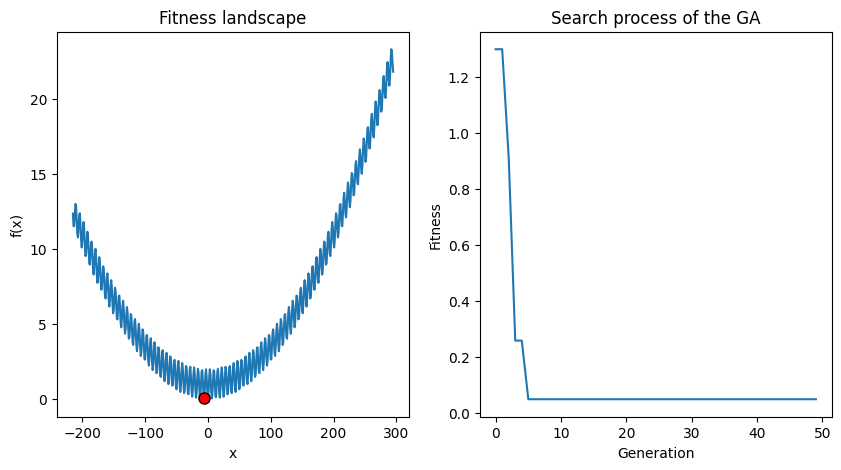

In [11]:
# set parameters
pop_size = 5
max_gen = 50
code_len = 9
pm = 1/code_len
pc = 0.8

fitness_func = Griewank
lower = lower_Griewank
upper = upper_Griewank

# run the GA with the given parameters
best_x, best_fitness, best_fitness_all = binary_coded_GA(pop_size, max_gen, pm, pc, code_len, fitness_func, lower, upper)
print(f'Minimum value of the function: {best_fitness}')


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# visualize the fitness landscape
x = np.arange(lower, upper)
y = fitness_func(x)
axs[0].plot(x, y)
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].set_title('Fitness landscape')
# show the best solution
axs[0].plot(binary_decode(best_x, lower, upper, code_len), best_fitness, marker="o", markersize=8, markeredgecolor="k", markerfacecolor="r")

# visualize the search process
axs[1].plot(best_fitness_all)
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Fitness')
axs[1].set_title('Search process of the GA')
plt.show()

## Part 1: Parameter Tuning (15 marks)

In this part, you are required to adjust the parameters (i.e., population size, maximum number of generations, code length, crossover probability, and mutation probability) of the **genetic algorithm provided in Part 0** and report your observations. 

Please note that there is **no need** to provide code snippets or graphics to support your observations. A brief discussion of your findings will suffice.

## Part 2: Minimization of The Two-Variable Rosenbrock Function (35 marks)
The Rosenbrock function with two decision variables is as follows:

\begin{align}
\begin{split}
f(x) &=& 100\times(x_2-x_1^2)^2+(x_1 - 1)^2 \\
&&-2.048 \leq x_i \leq 2.048 \quad \mathrm{for} \quad i=1,2
\end{split}
\end{align}

In this part, you are required to complete the following tasks:
1. Complete the TODO part of the code for the Rosenbrock function and display its fitness landscape using the code provided.

2. Implement a genetic algorithm (by borrowing code from Part 0 and making changes) to minimize the Rosenbrock function. Output the minimum value of the function, plot the best solution on the fitness landscape, and visually represent the search process, as demonstrated in Part 0.

3. Answer the question: What are the limitations of binary-coded genetic algorithms when used to solve problems with a large number of decision variables?


In [ ]:
def Rosenbrock(x1, x2):
    """
    Calculates the Rosenbrock function value for a given solution point (x1, x2).

    Parameters:
    x1 (numpy array): The first decision variable.
    x2 (numpy array): The second decision variable.

    Returns:
    numpy array: The Rosenbrock function value for each solution (x1, x2).

    """
    #-----------------BEGIN-----------------#
    # TODO: task 1 - implement the Rosenbrock function
    #------------------END------------------#
    return y


# visualize the fitness landscape
x1 = np.linspace(-2.048, 2.048, 100)
x2 = np.linspace(-2.048, 2.048, 100)
X1, X2 = np.meshgrid(x1, x2)
Y = Rosenbrock(X1, X2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Y)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Rosenbrock(x1, x2)')
plt.show()

## Part 3:  Investigation of Other Operators (50 marks)

In this part, you are required to complete the following tasks:

1. Implement proportionate selection, compare it with tournament selection, and report your findings.
2. Implement two-point crossover, compare it with single-point crossover, and report your findings.